In [7]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [8]:
DATA_ROOT = "/home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "valid")
TEST_DIR = os.path.join(DATA_ROOT, "test")
MODEL_SAVE_DIR = "retina_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# test_folder = '/home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/test'
# output_folder = '/home/ubuntu/CS230_final_project/CS230-final-project/yolo_v1_output_images'
# model_path = '/home/ubuntu/CS230_final_project/CS230-final-project/yolo_v1_weights/yolo_model_grid5_yololoss_lr0.00001_batch128.pth' #change path to the corresponding

In [ ]:
class DroneDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not os.path.exists(self.label_dir):
            raise FileNotFoundError(f"Label directory not found: {self.label_dir}")

        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        if len(self.image_files) == 0:
            raise FileNotFoundError(f"No jpg files found in {self.image_dir}")

        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        if image.shape[:2] != (640, 640):
            image = cv2.resize(image, (640, 640))

        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    
                    class_id = int(data[0])
                    x_center, y_center = float(data[1]), float(data[2])
                    width, height = float(data[3]), float(data[4])

                    x_min = (x_center - width/2) * 640
                    y_min = (y_center - height/2) * 640
                    x_max = (x_center + width/2) * 640
                    y_max = (y_center + height/2) * 640

                    x_min = max(0, min(x_min, 640))
                    y_min = max(0, min(y_min, 640))
                    x_max = max(0, min(x_max, 640))
                    y_max = max(0, min(y_max, 640))

                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)

        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        # Basic augmentations
        if self.train:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = np.fliplr(image).copy()
                boxes[:, [0, 2]] = 640 - boxes[:, [2, 0]]

            # Random brightness and contrast
            if np.random.random() > 0.5:
                alpha = 1.0 + np.random.uniform(-0.1, 0.1)
                beta = np.random.uniform(-10, 10)
                image = np.clip(alpha * image + beta, 0, 255).astype(np.uint8)

        # Convert to tensor
        image = (image / 255.0).astype(np.float32)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = normalize(image)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

Found 2827 images in /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/train/images


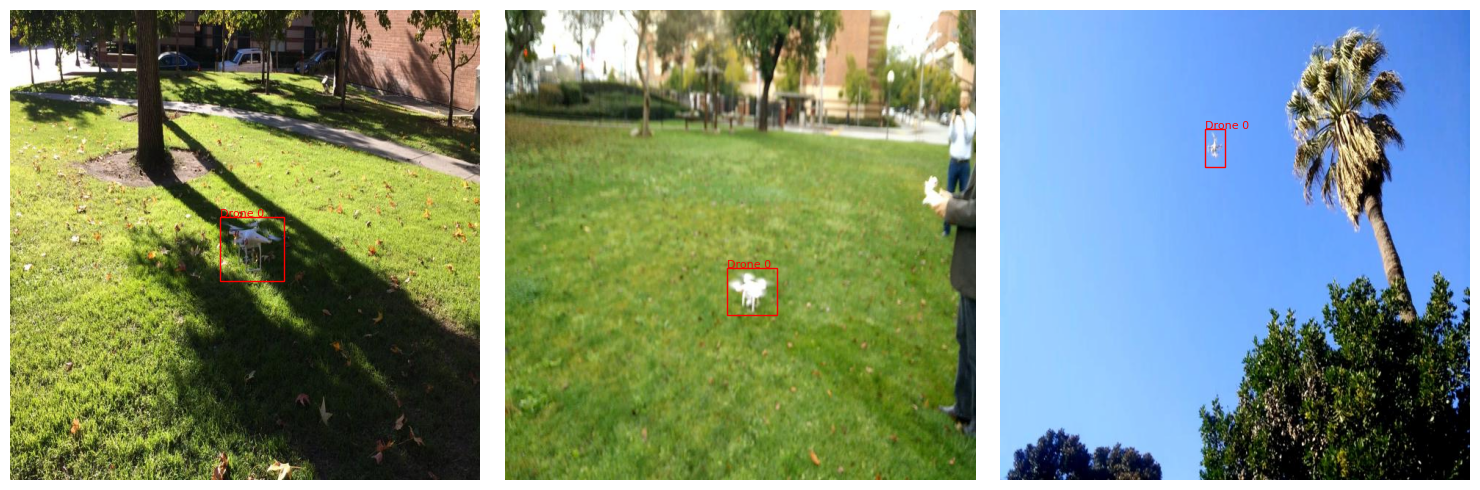


Example 1:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[267.5000, 280.7500, 354.5000, 368.2500]])
Labels:
tensor([0])

Example 2:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[270.7500, 350.7500, 338.2500, 415.2500]])
Labels:
tensor([0])

Example 3:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[334.2500, 161.5000, 360.7500, 213.5000]])
Labels:
tensor([0])


In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid

# Visualize images from the training set
def show_batch(dataset, num_examples=3):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

    for i in range(num_examples):
        image, target = dataset[i]
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)

        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color='red')
            axes[i].add_patch(rect)
            axes[i].text(x1, y1, f'Drone {label}',
                        color='red', fontsize=8)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

dataset = DroneDataset(TRAIN_DIR, train=True)
show_batch(dataset)

for i in range(3):
    image, target = dataset[i]
    print(f"\nExample {i+1}:")
    print(f"Image shape: {image.shape}")
    print(f"Number of objects: {len(target['boxes'])}")
    print(f"Bounding boxes:\n{target['boxes']}")
    print(f"Labels:\n{target['labels']}")

In [12]:
def get_transform(train):
    if train:
        transform = A.Compose([
            A.RandomResizedCrop(640, 640, scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    else:
        transform = A.Compose([
            A.Resize(640, 640),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    return transform

In [ ]:
def get_data_loaders(train_dir, val_dir, batch_size=4):
    train_dataset = DroneDataset(train_dir, train=True)
    val_dataset = DroneDataset(val_dir, train=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    return train_loader, val_loader

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % 10 == 0:
            print(f"Batch [{i+1}/{num_batches}], Loss: {losses.item():.4f}")

    return total_loss / num_batches

In [ ]:
def get_model(num_classes=2):
    weights = torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.DEFAULT
    model = retinanet_resnet50_fpn(weights=weights)
    num_anchors = model.head.classification_head.num_anchors

    num_classes = num_classes
    in_channels = 256

    cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.01)
    torch.nn.init.constant_(cls_logits.bias, -np.log((1 - 0.01) / 0.01))

    model.head.classification_head.num_classes = num_classes
    model.head.classification_head.cls_logits = cls_logits

    return model

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        assert isinstance(loss_dict, dict), f"Expected dict, got {type(loss_dict)}"
        losses = sum(loss for loss in loss_dict.values())

        total_loss += losses.item()

    return total_loss / num_batches

In [ ]:
def main():
    print(f"Training data directory: {TRAIN_DIR}")
    print(f"Validation data directory: {VAL_DIR}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        train_loader, val_loader = get_data_loaders(
            train_dir=TRAIN_DIR,
            val_dir=VAL_DIR,
            batch_size=4
        )
        print("Data loaders created")

        model = get_model(num_classes=2)
        model.to(device)
        print("Model initialized")

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params, lr=1e-5)
        num_epochs = 50

        best_loss = float('inf')
        model_save_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

        print("Starting training")
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss = train_one_epoch(model, optimizer, train_loader, device)
            val_loss = evaluate(model, val_loader, device)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved new best model with validation loss: {val_loss:.4f}")

    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

In [16]:
if __name__ == '__main__':
    main()

Training data directory: /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/train
Validation data directory: /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/valid
Using device: cuda
Found 2827 images in /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/train/images
Found 807 images in /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/valid/images
Data loaders created successfully
Initializing model...
Model initialized successfully
Starting training...

Epoch 1/50
Batch [10/707], Loss: 1.5630
Batch [20/707], Loss: 1.7264
Batch [30/707], Loss: 1.3310
Batch [40/707], Loss: 1.0653
Batch [50/707], Loss: 0.9617
Batch [60/707], Loss: 0.9930
Batch [70/707], Loss: 0.6776
Batch [80/707], Loss: 1.1693
Batch [90/707], Loss: 0.8665
Batch [100/707], Loss: 0.9189
Batch [110/707], Loss: 0.9895
Batch [120/707], Loss: 0.5155
Batch [130/707], Loss: 0.8200
Batch [140/707], Loss: 0.6710
Batch [150/707], Loss: 0.4841
Batch [160/707], Loss

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

def detect_and_save(model, image_path, output_folder, device, confidence_threshold=0.5):
    os.makedirs(output_folder, exist_ok=True)

    transform = get_transform(train=False)
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    transformed = transform(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Draw boxes on image
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
        draw.text((x1, y1-10), f'Drone: {score:.2f}', fill='red')

    output_path = os.path.join(output_folder, f'detected_{os.path.basename(image_path)}')
    image_draw.save(output_path)
    print(f"Saved annotated image to {output_path}")

    return boxes, scores, labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)
model.load_state_dict(torch.load('retina_models/best_model.pth'))
model.to(device)

test_image_folder = TEST_DIR + '/images'
output_folder = 'retina_output_images_50_epochs'

for image_file in os.listdir(test_image_folder):
    if image_file.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(test_image_folder, image_file)
        print(f"\nProcessing {image_file}")
        boxes, scores, labels = detect_and_save(model, image_path, output_folder, device)

/tmp/ipykernel_169124/2579056594.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retina_models/best_model.pth'))



Processing video18_1313_JPEG.rf.964a26819c2232b0ffe73bc8c4554245.jpg
Saved annotated image to retina_output_images_50_epochs/detected_video18_1313_JPEG.rf.964a26819c2232b0ffe73bc8c4554245.jpg

Processing video18_1099_JPEG.rf.566fb1989c2b3cfef22709d49dfc4d0e.jpg
Saved annotated image to retina_output_images_50_epochs/detected_video18_1099_JPEG.rf.566fb1989c2b3cfef22709d49dfc4d0e.jpg

Processing 0218_jpg.rf.a4985127caf56f70332bad0183b9df62.jpg
Saved annotated image to retina_output_images_50_epochs/detected_0218_jpg.rf.a4985127caf56f70332bad0183b9df62.jpg

Processing video18_2115_JPEG.rf.50f466219a80fdaa5ac70b92fdaa6054.jpg
Saved annotated image to retina_output_images_50_epochs/detected_video18_2115_JPEG.rf.50f466219a80fdaa5ac70b92fdaa6054.jpg

Processing video16_228_JPEG.rf.0b79bb8948b64669c119c6a0fe5889d2.jpg
Saved annotated image to retina_output_images_50_epochs/detected_video16_228_JPEG.rf.0b79bb8948b64669c119c6a0fe5889d2.jpg

Processing video17_833_JPEG.rf.56ef439405d4a1cc84a87a1

In [ ]:
import numpy as np
from collections import defaultdict

def calculate_iou(box1, box2):

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = box1_area + box2_area - intersection
    iou = intersection / union if union > 0 else 0
    
    return iou

def evaluate_detections(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):

    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return {
            'precision': 1.0,
            'recall': 1.0,
            'f1_score': 1.0,
            'mean_iou': 0.0
        }
    
    if len(pred_boxes) == 0:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'mean_iou': 0.0
        }
    
    if len(gt_boxes) == 0:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'mean_iou': 0.0
        }

    pred_boxes = np.array(pred_boxes)
    gt_boxes = np.array(gt_boxes)
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    matched_ious = []
    
    gt_matched = [False] * len(gt_boxes)
    
    sorted_indices = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_indices]
    pred_labels = pred_labels[sorted_indices]
    
    for pred_idx, pred_box in enumerate(pred_boxes):
        max_iou = -np.inf
        max_idx = -1
        
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_matched[gt_idx]:
                continue
                
            if pred_labels[pred_idx] != gt_labels[gt_idx]:
                continue
                
            iou = calculate_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                max_idx = gt_idx
        
        if max_iou >= iou_threshold:
            true_positives += 1
            gt_matched[max_idx] = True
            matched_ious.append(max_iou)
        else:
            false_positives += 1
    
    # Count unmatched ground truth boxes as false negatives
    false_negatives = len(gt_boxes) - sum(gt_matched)
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    mean_iou = np.mean(matched_ious) if matched_ious else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_iou': mean_iou,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

def evaluate_model(model, test_dataset, device, confidence_threshold=0.5, iou_threshold=0.5):
    
    model.eval()
    metrics_sum = defaultdict(float)
    num_images = len(test_dataset)
    
    with torch.no_grad():
        for i in range(num_images):
            # Get image and ground truth
            image, target = test_dataset[i]
            image = image.unsqueeze(0).to(device)
            predictions = model(image)
            
            pred_boxes = predictions[0]['boxes'].cpu().numpy()
            pred_scores = predictions[0]['scores'].cpu().numpy()
            pred_labels = predictions[0]['labels'].cpu().numpy()
            
            mask = pred_scores >= confidence_threshold
            pred_boxes = pred_boxes[mask]
            pred_scores = pred_scores[mask]
            pred_labels = pred_labels[mask]
            
            gt_boxes = target['boxes'].numpy()
            gt_labels = target['labels'].numpy()
            
            metrics = evaluate_detections(
                pred_boxes, pred_scores, pred_labels,
                gt_boxes, gt_labels, iou_threshold
            )
            
            for k, v in metrics.items():
                metrics_sum[k] += v
    
    metrics_avg = {k: v / num_images for k, v in metrics_sum.items()}
    
    return metrics_avg

In [25]:
test_dataset = DroneDataset(TEST_DIR, train=False)

metrics = evaluate_model(
    model=model,
    test_dataset=test_dataset,
    device=device,
    confidence_threshold=0.5,
    iou_threshold=0.5
)

print("\nEvaluation Results:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"Average IoU: {metrics['mean_iou']:.4f}")

Found 396 images in /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/test/images

Evaluation Results:
Precision: 0.9040
Recall: 0.9242
F1 Score: 0.9078
Average IoU: 0.7240
